### Importação de bibliotecas

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

### Carregamento do dataset
Leitura dos dados de consumo energético. Esta etapa é crítica para garantir que o formato e codificação do CSV sejam corretamente interpretados.

In [4]:
df = pd.read_csv('../Data/powerconsumption.csv')
df.head()

Datetime  Temperature  Humidity  WindSpeed  GeneralDiffuseFlows  \
0  1/1/2017 0:00        6.559      73.8      0.083                0.051   
1  1/1/2017 0:10        6.414      74.5      0.083                0.070   
2  1/1/2017 0:20        6.313      74.5      0.080                0.062   
3  1/1/2017 0:30        6.121      75.0      0.083                0.091   
4  1/1/2017 0:40        5.921      75.7      0.081                0.048   

   DiffuseFlows  PowerConsumption_Zone1  PowerConsumption_Zone2  \
0         0.119             34055.69620             16128.87538   
1         0.085             29814.68354             19375.07599   
2         0.100             29128.10127             19006.68693   
3         0.096             28228.86076             18361.09422   
4         0.085             27335.69620             17872.34043   

   PowerConsumption_Zone3  
0             20240.96386  
1             20131.08434  
2             19668.43373  
3             18899.27711  
4             18442.40964

### Diagnóstico estrutural
Fornece uma visão consolidada da dimensionalidade, tipos de variáveis e possíveis colunas com alta proporção de valores nulos, o que influencia diretamente decisões de pré-processamento.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52416 entries, 0 to 52415
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Datetime                52416 non-null  object 
 1   Temperature             52416 non-null  float64
 2   Humidity                52416 non-null  float64
 3   WindSpeed               52416 non-null  float64
 4   GeneralDiffuseFlows     52416 non-null  float64
 5   DiffuseFlows            52416 non-null  float64
 6   PowerConsumption_Zone1  52416 non-null  float64
 7   PowerConsumption_Zone2  52416 non-null  float64
 8   PowerConsumption_Zone3  52416 non-null  float64
dtypes: float64(8), object(1)
memory usage: 3.6+ MB


In [6]:
df.describe()

Temperature      Humidity     WindSpeed  GeneralDiffuseFlows  \
count  52416.000000  52416.000000  52416.000000         52416.000000   
mean      18.810024     68.259518      1.959489           182.696614   
std        5.815476     15.551177      2.348862           264.400960   
min        3.247000     11.340000      0.050000             0.004000   
25%       14.410000     58.310000      0.078000             0.062000   
50%       18.780000     69.860000      0.086000             5.035500   
75%       22.890000     81.400000      4.915000           319.600000   
max       40.010000     94.800000      6.483000          1163.000000   

       DiffuseFlows  PowerConsumption_Zone1  PowerConsumption_Zone2  \
count  52416.000000            52416.000000            52416.000000   
mean      75.028022            32344.970564            21042.509082   
std      124.210949             7130.562564             5201.465892   
min        0.011000            13895.696200             8560.081466   
25%        0.122000            26310.668692            16980.766032   
50%        4.456000            32265.920340            20823.168405   
75%      101.000000            37309.018185            24713.717520   
max      936.000000            52204.395120            37408.860760   

       PowerConsumption_Zone3  
count            52416.000000  
mean             17835.406218  
std               6622.165099  
min               5935.174070  
25%              13129.326630  
50%              16415.117470  
75%              21624.100420  
max              47598.326360

### Avaliação de valores ausentes

In [7]:
df.isnull().sum()

Datetime                  0
Temperature               0
Humidity                  0
WindSpeed                 0
GeneralDiffuseFlows       0
DiffuseFlows              0
PowerConsumption_Zone1    0
PowerConsumption_Zone2    0
PowerConsumption_Zone3    0
dtype: int64

In [8]:
df.isna().sum()

Datetime                  0
Temperature               0
Humidity                  0
WindSpeed                 0
GeneralDiffuseFlows       0
DiffuseFlows              0
PowerConsumption_Zone1    0
PowerConsumption_Zone2    0
PowerConsumption_Zone3    0
dtype: int64

### Processamento auxiliar
Etapa intermediária com manipulações orientadas à inspeção exploratória ou preparação para análises posteriores.

In [9]:
df['TotalConsumption'] = df['PowerConsumption_Zone1'] + df['PowerConsumption_Zone2'] + df['PowerConsumption_Zone3']

In [10]:
df['Datetime'] = pd.to_datetime(df['Datetime'])
df['Datetime'] = df['Datetime'].dt.hour
df.rename(columns={'Datetime': 'Hour'}, inplace=True)

In [11]:
df.head()

Hour  Temperature  Humidity  WindSpeed  GeneralDiffuseFlows  DiffuseFlows  \
0     0        6.559      73.8      0.083                0.051         0.119   
1     0        6.414      74.5      0.083                0.070         0.085   
2     0        6.313      74.5      0.080                0.062         0.100   
3     0        6.121      75.0      0.083                0.091         0.096   
4     0        5.921      75.7      0.081                0.048         0.085   

   PowerConsumption_Zone1  PowerConsumption_Zone2  PowerConsumption_Zone3  \
0             34055.69620             16128.87538             20240.96386   
1             29814.68354             19375.07599             20131.08434   
2             29128.10127             19006.68693             19668.43373   
3             28228.86076             18361.09422             18899.27711   
4             27335.69620             17872.34043             18442.40964   

   TotalConsumption  
0       70425.53544  
1       69320.84387  
2       67803.22193  
3       65489.23209  
4       63650.44627

### Detecção e remoção de outliers com Isolation Forest

Aplica-se o algoritmo Isolation Forest, configurado com taxa de contaminação de 5%, para identificar observações anômalas exclusivamente entre variáveis numéricas. Os outliers detectados são excluídos do conjunto original, preservando uma cópia (`df_old`) para posterior análise de impacto.

A integridade dos dados é então calculada como a proporção de registros mantidos após a limpeza. Esse indicador é útil para avaliar se a remoção de anomalias comprometeu significativamente a amostra original.


In [12]:
clf = IsolationForest(contamination=0.05)
outliers = clf.fit_predict(df.select_dtypes(include='number'))
df_old = df.copy()
df = df[outliers == 1]

n_of_outliers = df_old.shape[0] - df.shape[0]
integrity = (1 - n_of_outliers/df_old.shape[0]) * 100

print(f'Removed {n_of_outliers} outliers.\nIntegrity now: {integrity:.2f}%.')

Removed 2621 outliers.
Integrity now: 95.00%.


### Análise visual
Exploração gráfica para compreender correlações, tendências e comportamento de variáveis. Visualizações eficazes antecipam padrões complexos difíceis de captar numericamente.

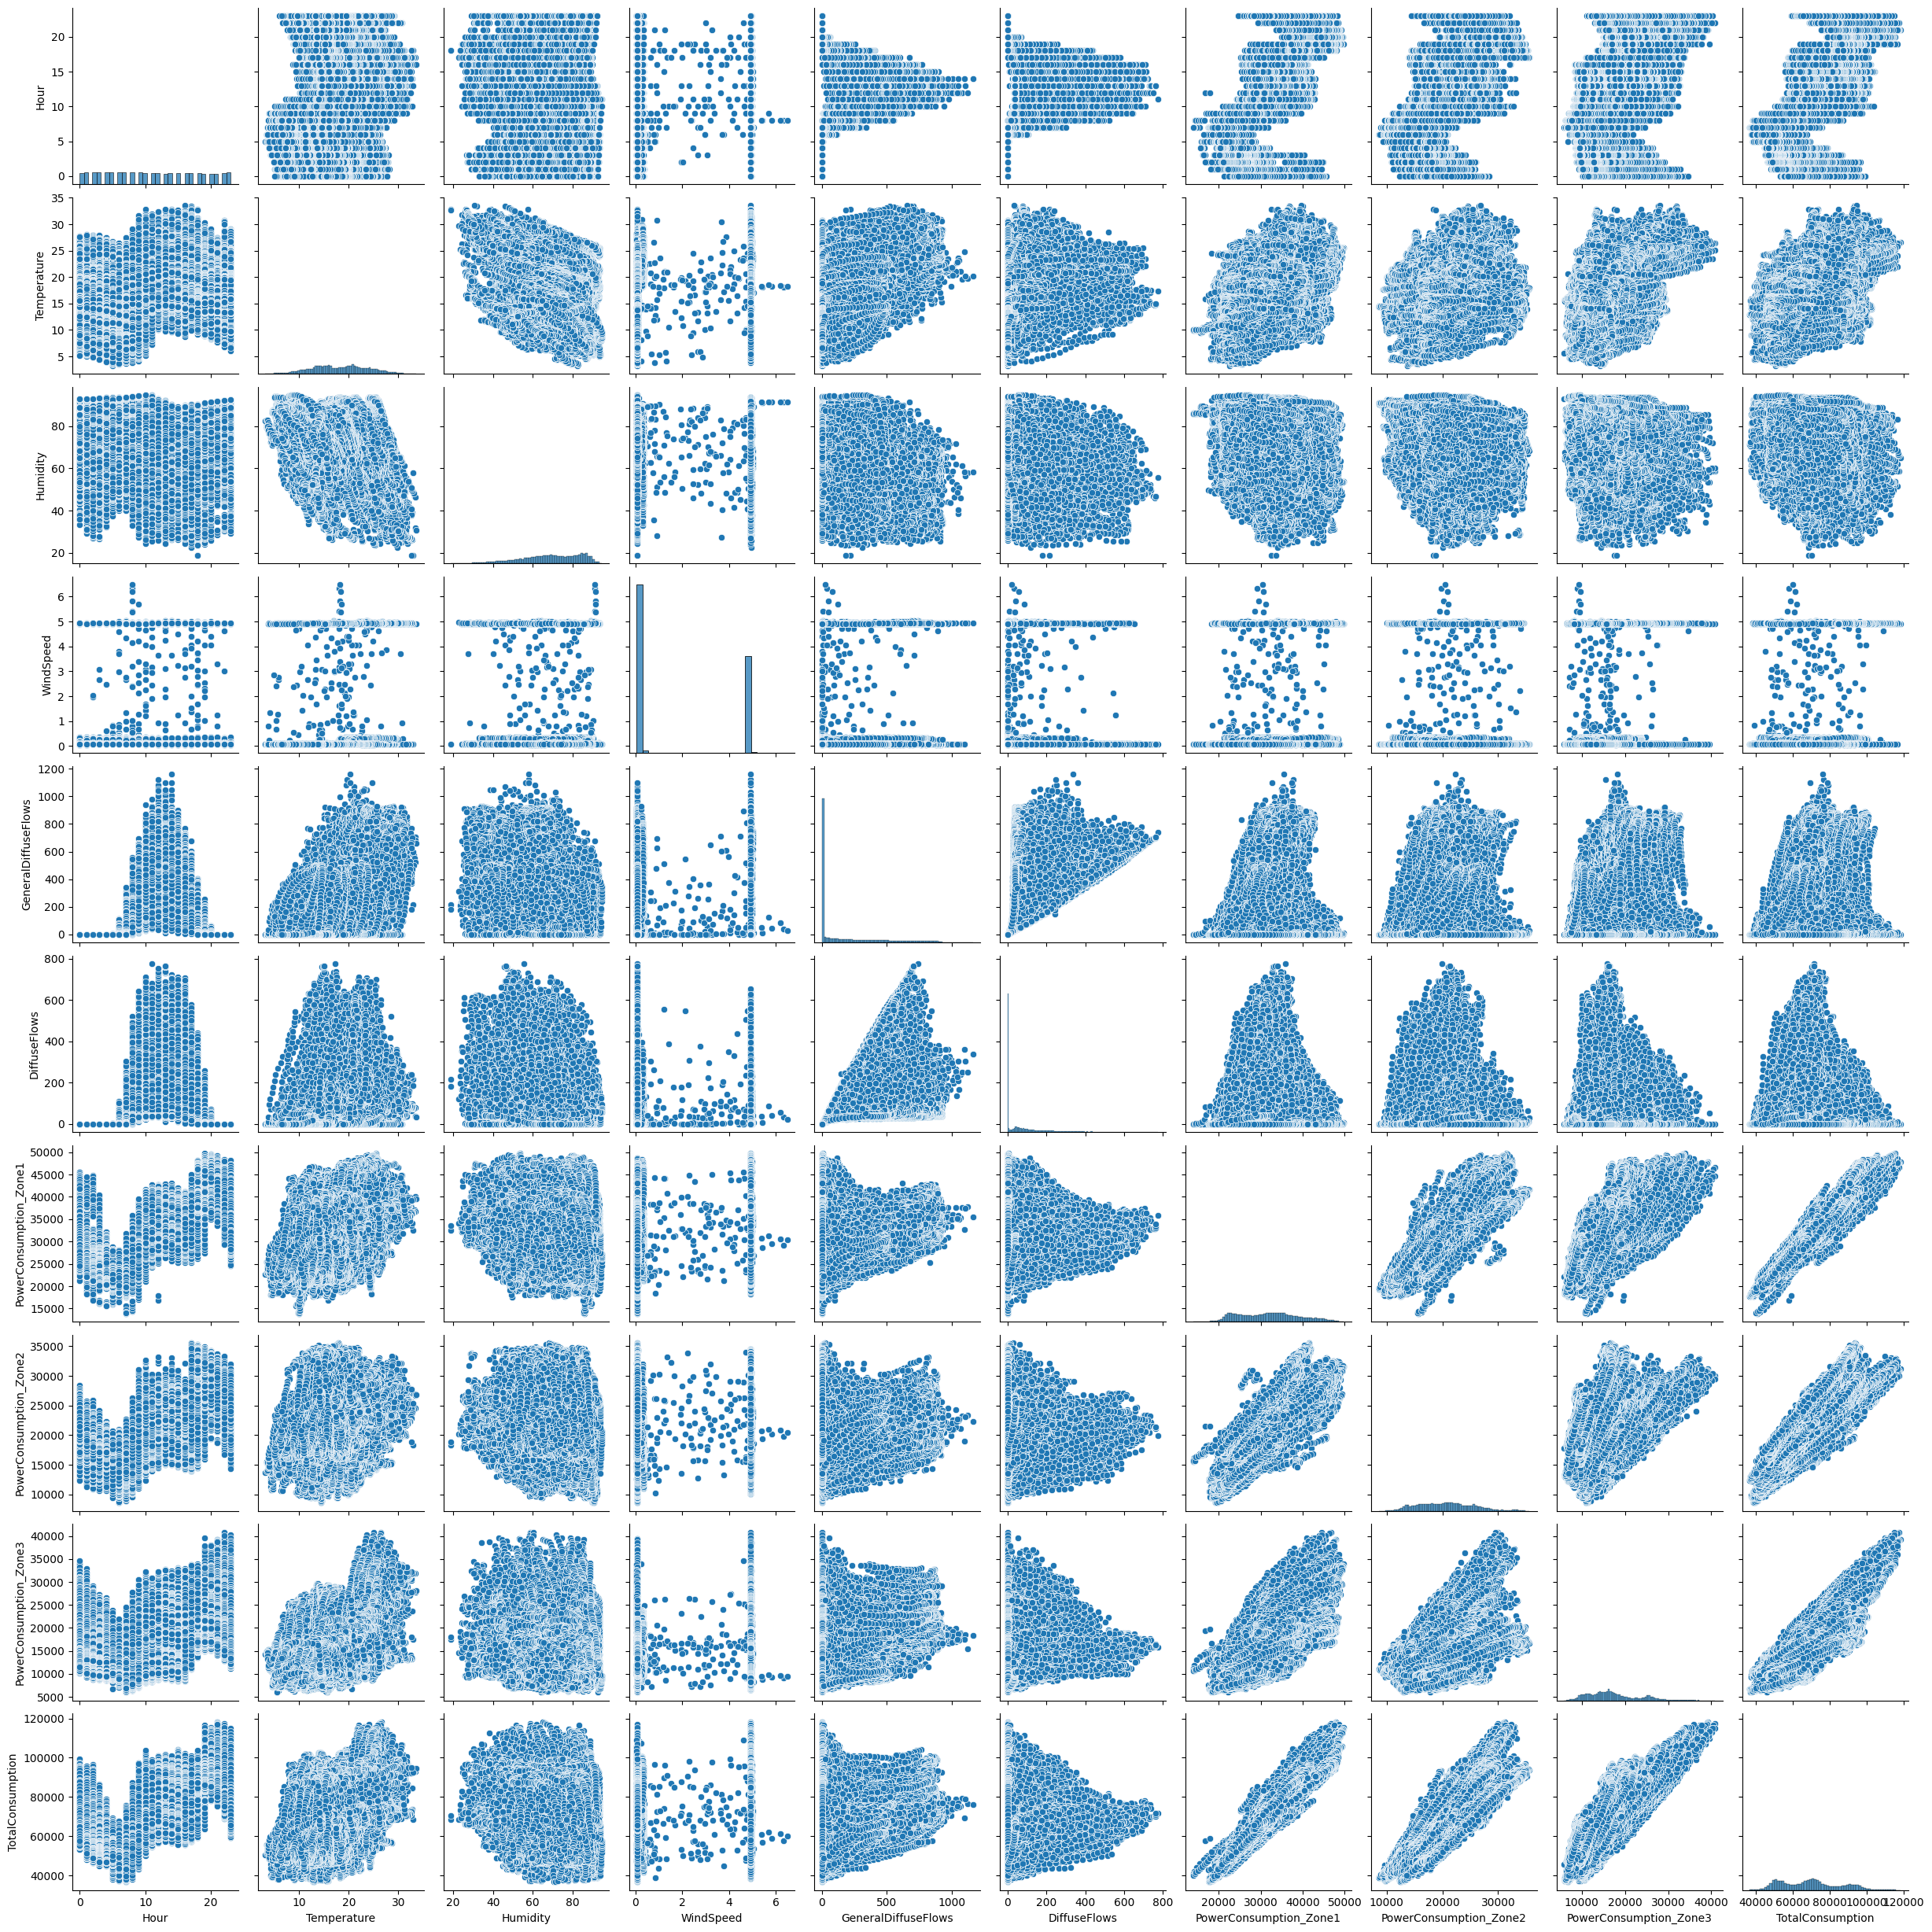

In [13]:
sns.pairplot(df)
plt.show()

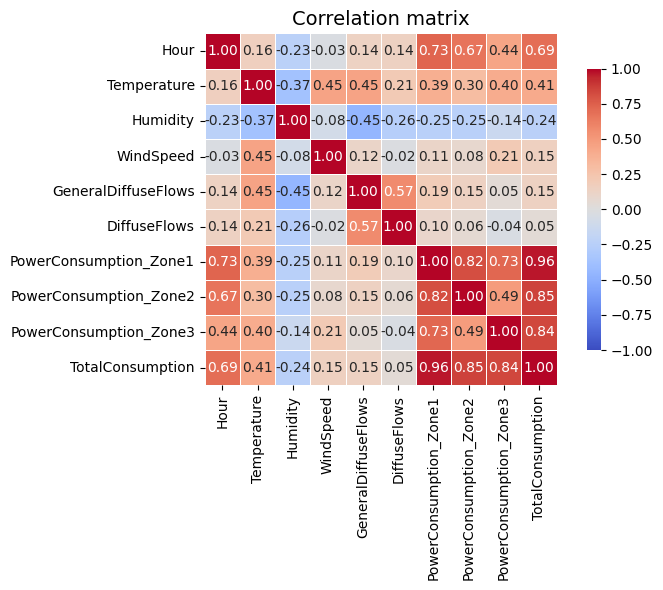

In [14]:
corr = df.corr()

plt.figure(figsize=(8, 6))

sns.heatmap(
    corr,
    annot=True,         # Mostra os valores dentro das células
    fmt=".2f",          # Formato dos números
    cmap="coolwarm",    # Paleta de cores
    vmin=-1, vmax=1,    # Escala fixa entre -1 e 1
    square=True,        # Células quadradas
    linewidths=0.5,     # Linhas entre as células
    cbar_kws={"shrink": .8}  # Barra de cores mais compacta
)

plt.title("Correlation matrix", fontsize=14)
plt.tight_layout()
plt.show()

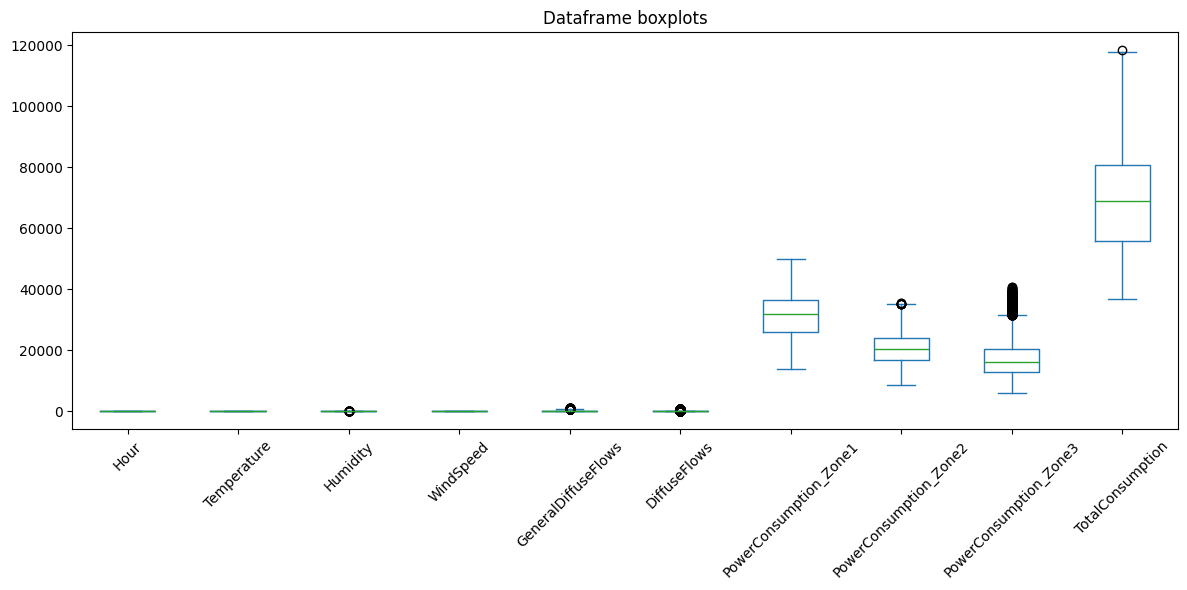

In [15]:
df.plot(kind='box', figsize=(12, 6))
plt.title("Dataframe boxplots")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

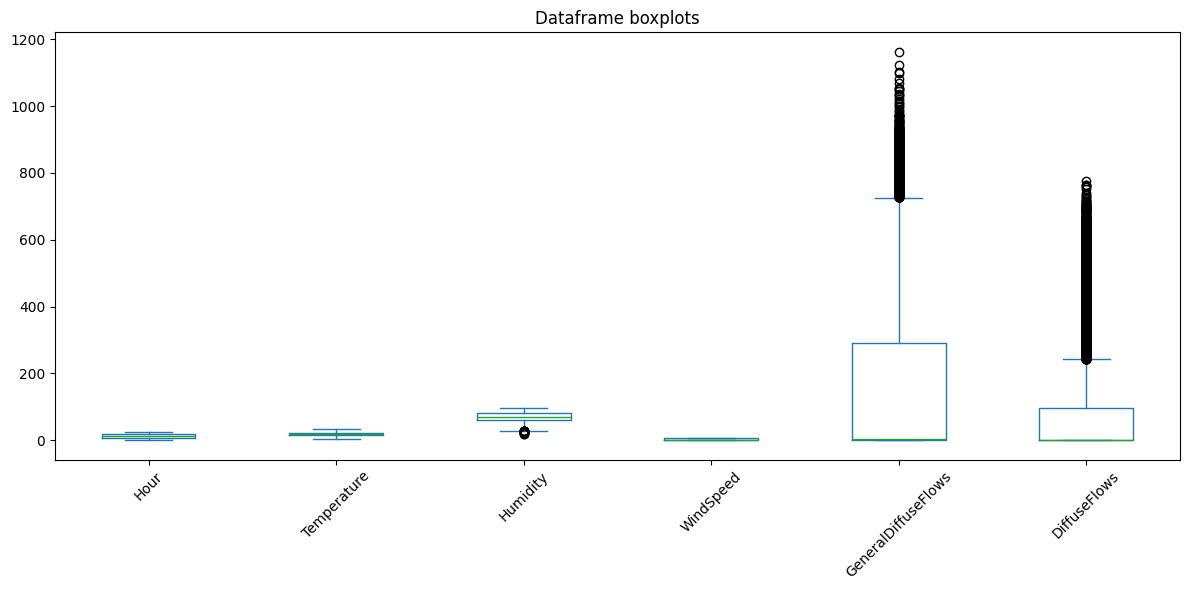

In [16]:
cls = ['PowerConsumption_Zone1',
       'PowerConsumption_Zone2',
       'PowerConsumption_Zone3',
       'TotalConsumption']

df.drop(cls, axis=1).plot(kind='box', figsize=(12, 6))
plt.title("Dataframe boxplots")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Exportação do dataset tratado

In [17]:
df.to_csv('../Data/powerconsumption_after_EDA.csv', index=False)